# Figure 2 - Benchmarking PBMCs

Install required packages

## Configure Environment & Helper Functions

In [ ]:
#%%capture
#!pip install scanpy adjustText progressbar2 more_itertools leidenalg

In [1]:
%reload_ext autoreload
%autoreload 2
%timeit

# Add repo path to system path if it is not already there
# This allows us to import the package
import sys
GIT_REPO_PATH = "/home/jupyter/github_repos/"
if GIT_REPO_PATH not in sys.path: sys.path.append(GIT_REPO_PATH)

# Set global configuration
!git config --global user.email daniel.charytonowicz@icahn.mssm.edu
!git config --global user.name dchary

# make the repo if it doesnt exist
!mkdir /home/jupyter/github_repos/

# Import base packages required
import sys, os, scipy, random, gc, warnings, re, anndata
import numpy as np
import pandas as pd
import scanpy as sc
from importlib import reload
from tqdm.auto import tqdm
import tensorflow as tf
import textwrap
import matplotlib as mpl
import matplotlib.pyplot as plt
import scaden
import glob

import ucdeconvolve_old.ucdeconvolve as ucd
from ucdeconvolve.ucdeconvolve import _utils as ucdutils
from ucdeconvolve.ucdeconvolve._experimental import _exputils as ucdexputils

mkdir: cannot create directory ‘/home/jupyter/github_repos/’: File exists


2022-12-15 13:22:20.905216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 13:22:20.977216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 13:22:20.977896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 13:22:20.980268: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
# Load the unicell basemodel
modelpath = "/home/jupyter/data/unicell_deconvolve_v2.2_10M_production.h5ucd"
basemodel = tf.keras.models.load_model(modelpath, custom_objects={'tf': tf}, compile = False)

/opt/conda/lib/python3.7/site-packages/keras/layers/core.py:1045: UserWarning: unicell.tensorflow.deconvolve.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [5]:
from typing import List, Optional, Union, Tuple

def cell_cycle_scoring(
    adata : anndata.AnnData
) -> anndata.AnnData:
    """\
    Cell Cycle Scoring
    
    Utility function that performs cell cycle scoring on annotated dataset.
    
    Params
    ------
    adata
        an annotated dataset object
    
    Returns
    ------
    adata : anndata.AnnData
        an annotated dataset object with cell cycle scores in 'adata.obs'
        
    """
    
    #Open cell cycle genes from a reference file
    cell_cycle_genes = [x.strip() for x in open('data/cell_cycle_genes.txt')]

    # Separate S and G2M genes, and keep only those in the annotated dataset
    s_genes = cell_cycle_genes[:43]
    g2m_genes = cell_cycle_genes[43:]
    cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
    
    #Perform actual cell cycle scoring
    sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

    # Return result
    return adata


def preprocess_adata(
    adata : anndata.AnnData, 
    var_min_total_counts : int, 
    var_max_total_counts : int,
    var_min_genes_per_cell : int,
    var_max_genes_per_cell : int,
    var_mito_ratio_limit : int,
    var_gene_min_counts : int,
    normalize_target_sum : float,
    variable_genes_min_mean : float,
    variable_genes_max_mean : float,
    variable_genes_min_disp : float,
    regress_obs : List[str],
    max_scale_value : int,
    cell_cycle_regression : bool = True
) -> anndata.AnnData:
    """\
    Preprocess Annotated Dataset
    
    Performing preprocessing on raw annotated dataset using specificed parameters.
    
    Params
    ------
    adata
        An annotated dataset
    var_min_total_counts
        Minimum total counts per cell.
    var_max_total_counts
        Maximum total counts per cell.
    var_min_genes_per_cell
        Minimum number of genes per cell.
    var_max_genes_per_cell
        Maximum number of genes per cell.
    var_mito_ratio_limit
        Limit percentage of genes coming from
        mitochondria, a sign of damaged or
        dead cells.
    var_gene_min_counts
        Minimum counts for a gene to keep it.
    normalize_target_sum
        Number of counts to normalize each cell to.
    variable_genes_min_mean
        Minimum log mean for potential highly-variable gene.
    variable_genes_max_mean
        Maximum log mean for potential highly-variable gene.
    variable_genes_min_disp
        Minimum dispersion to consider a gene highly-variable.
    regress_obs
        Columns in obs to use for count regression.
    max_scale_value
        Max/min value (+/-) to use when z-score rescaling data.
    cell_cycle_regression
        Whether or not to do cell cycle regression. Default True.
        
    Returns
    ------
    adata : anndata.AnnData
        A preprocessed annotated dataset.
        
    """
    
    # Make gene names unique if they are not
    adata.var_names_make_unique()

    # Make all gene names uppercase
    adata.var_names = adata.var_names.str.upper()

    # Filter cells and genes by above thresholds
    sc.pp.filter_cells(adata, min_counts = var_min_total_counts, inplace = True)
    sc.pp.filter_cells(adata, max_counts = var_max_total_counts, inplace = True)
    sc.pp.filter_cells(adata, min_genes = var_min_genes_per_cell, inplace = True)
    sc.pp.filter_cells(adata, max_genes = var_max_genes_per_cell, inplace = True)
    #sc.pp.filter_genes(adata, min_counts = var_gene_min_counts, inplace = True)

    # Calculate QC metrics specific to mitochondrial genes
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top = None, log1p = False, inplace = True)

    # Keep cells with a mitochondrial fraction below the threshhold above
    adata = adata[adata.obs.pct_counts_mt < var_mito_ratio_limit, :]

    # Normalize UMI counts to 10,000 per cell 
    sc.pp.normalize_total(adata, target_sum=normalize_target_sum)

    # Logp-scale the data log(x + 1)
    sc.pp.log1p(adata)

    # Find highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=10, min_disp=0.25)

    # Set raw data to be equal to the normalized and log-scaled data
    adata.raw = adata

    # Only keep highly variable genes for downstream clustering operations
    adata = adata[:, adata.var.highly_variable]

    # Get cell-cycle genes
    if cell_cycle_regression: adata = cell_cycle_scoring(adata)
    
    # Regress out the effect of mitochondria and total counts
    # Also do cell cycle if desired
    if cell_cycle_regression:
        sc.pp.regress_out(adata, regress_obs + ['S_score','G2M_score'])
    else:
        sc.pp.regress_out(adata, regress_obs)

    # Rescale all data to unit variance
    sc.pp.scale(adata, max_value = max_scale_value)

    # Make data sparse prior to storage
    adata.X = scipy.sparse.csr_matrix(adata.X)

    return adata

def cluster_adata(adata : anndata.AnnData,
    var_pca_components : int, 
    var_n_neighbors : int, 
    var_umap_min_dist : float,
    use_rep : Optional[str] = None,
    harmony_batch : Optional[str] = 'batch',
    use_harmony : bool = False
) -> anndata.AnnData:
    """\
    Cluster Annotated Dataset
    
    Perform clustering according to parameters, including batch-correction.
    
    Params
    ------
    adata
        An annotated dataset
    var_pca_components
        Number of PCA components to generate.
    var_n_neighbors
        Number of nearest neighbors to use for clustering
    var_umap_min_dist
        Minimum distance for UMAP embedding.
    use_rep
        What rep to use for neighbors calculation, if None default is X_Pca
    harmony_batch
        What to use as batch key for harmony batch correction.
    use_harmony
        Whether or not to use harmony.
    
    Returns
    -------
    adata : anndata.AnnData
        An annotated datset with clustering and embedding data.
        
    """
    
    # Run PCA embedding
    sc.tl.pca(adata, svd_solver='arpack', n_comps = var_pca_components)
    
    # Run Harmony Batch Correction
    if use_harmony:
        sc.external.pp.harmony_integrate(adata, key = harmony_batch, 
                            basis = 'X_pca', adjusted_basis = 'X_pca_harmony')
        use_rep = 'X_pca_harmony'

    # Neighbors and UMAP embedding
    sc.pp.neighbors(adata, use_rep = use_rep, 
        n_neighbors = var_n_neighbors, n_pcs = var_pca_components)
    sc.tl.umap(adata, min_dist = var_umap_min_dist)
    
    #Unsupervised clustering and cluster enrichment
    sc.tl.leiden(adata)
    sc.tl.rank_genes_groups(adata, 'leiden', method='logreg', use_raw = True)

    return adata

## Deconvolution Benchmarks

### Human PBMCs

#### Process Raw Data

In [ ]:
adata = sc.read_10x_h5("/home/jupyter/manuscript/figure2/data/pbmc/10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.h5")

In [ ]:
# Preprocess raw data
adata = preprocess_adata(adata, 
            var_min_total_counts = 200, var_max_total_counts = 100000,
            var_min_genes_per_cell = 200, var_max_genes_per_cell = 50000,
            var_mito_ratio_limit = 10, var_gene_min_counts = 0, normalize_target_sum = 1E4, 
            variable_genes_min_mean = 0.0125, variable_genes_max_mean = 3,
            variable_genes_min_disp = 0.5, regress_obs = ['total_counts','pct_counts_mt'], max_scale_value = 10,
            cell_cycle_regression = True)

# Integrate with harmony, dimensionality reduce, cluster, and rank cluster DEGs
adata = cluster_adata(adata, var_pca_components = 75, var_n_neighbors = 30, 
            var_umap_min_dist = 0.1, harmony_batch = None, use_harmony = False)

# Annotate
adata.obs['celltype'] = 'unknown'
adata.obs.loc[adata.obs.leiden.isin(('0','2')), 'celltype'] = 'cd4-positive, alpha-beta t cell'
adata.obs.loc[adata.obs.leiden.isin(('4','')), 'celltype'] = 'cd8-positive, alpha-beta t cell'
adata.obs.loc[adata.obs.leiden.isin(('7','')), 'celltype'] = 'natural killer cell'
adata.obs.loc[adata.obs.leiden.isin(('5','')), 'celltype'] = 'b cell'
adata.obs.loc[adata.obs.leiden.isin(('1','3','8','6')), 'celltype'] = 'monocyte'
adata.obs.loc[adata.obs.leiden.isin(('10','')), 'celltype'] = 'conventional dendritic cell'
adata.obs.loc[adata.obs.leiden.isin(('13','')), 'celltype'] = 'plasmacytoid dendritic cell'
adata.obs.loc[adata.obs.leiden.isin(('14','')), 'celltype'] = 'platelet'

# Save
adata.write_h5ad("/home/jupyter/manuscript/figure2/data/pbmc/adata_pbmc_10k_pp_annots.h5ad")

# Generate a mixture
adata_mixture = ucd.tl.generate_mixtures(adata, key = 'celltype', complexity = 5, size = 100, number = 500,
                        mixture_pair_keys = [
                            ('cd4-positive, alpha-beta t cell','cd4-positive, alpha-beta t cell', 'primary'),
                            ('cd8-positive, alpha-beta t cell', 'cd8-positive, alpha-beta t cell', 'primary'),
                            ('monocyte', 'monocyte', 'primary'),
                            ('b cell', 'b cell', 'primary'),
                            ('natural killer cell','natural killer cell','primary'),
                            ('plasmacytoid dendritic cell', 'plasmacytoid dendritic cell', 'primary'),
                            ('conventional dendritic cell','conventional dendritic cell','primary'),
                            ('platelet','platelet','primary'),
                        ])

# Deconvolve mixture and save results
ucp_mixture_primary, _, _ = ucd.tl.deconvolve(adata_mixture, basemodel, split = True, propagate = True)
adata_mixture.write_h5ad("/home/jupyter/manuscript/figure2/data/pbmc/adata_pbmc_10k_pp_MIXTURE_c5_s100_n500_d0.h5ad")

#### Reload Preprocessed Data

In [3]:
mixture_pair_keys = [
                            ('cd4-positive, alpha-beta t cell','cd4-positive, alpha-beta t cell', 'primary'),
                            ('cd8-positive, alpha-beta t cell', 'cd8-positive, alpha-beta t cell', 'primary'),
                            ('monocyte', 'monocyte', 'primary'),
                            ('b cell', 'b cell', 'primary'),
                            ('natural killer cell','natural killer cell','primary'),
                            ('plasmacytoid dendritic cell', 'plasmacytoid dendritic cell', 'primary'),
                            ('conventional dendritic cell','conventional dendritic cell','primary'),
                            ('platelet','platelet','primary'),
                    ]

In [5]:
adata_10k_reference_pp = sc.read_h5ad("/home/jupyter/manuscript/figure2/data/pbmc/adata_pbmc_10k_pp_annots.h5ad")
adata_10k_mixture_pp = sc.read_h5ad("/home/jupyter/manuscript/figure2/data/pbmc/adata_pbmc_10k_pp_MIXTURE_c5_s100_n500_d0.h5ad")
adata_5k_reference_pp = sc.read_h5ad("/home/jupyter/manuscript/figure2/data/pbmc/adata_pbmc_5k_pp_annots.h5ad")
adata_5k_reference_pp = adata_5k_reference_pp[adata_5k_reference_pp.obs.celltype.ne('unknown')].copy()

#### Plot Figure 2a

Trying to set attribute `._uns` of view, copying.


(3, 3)


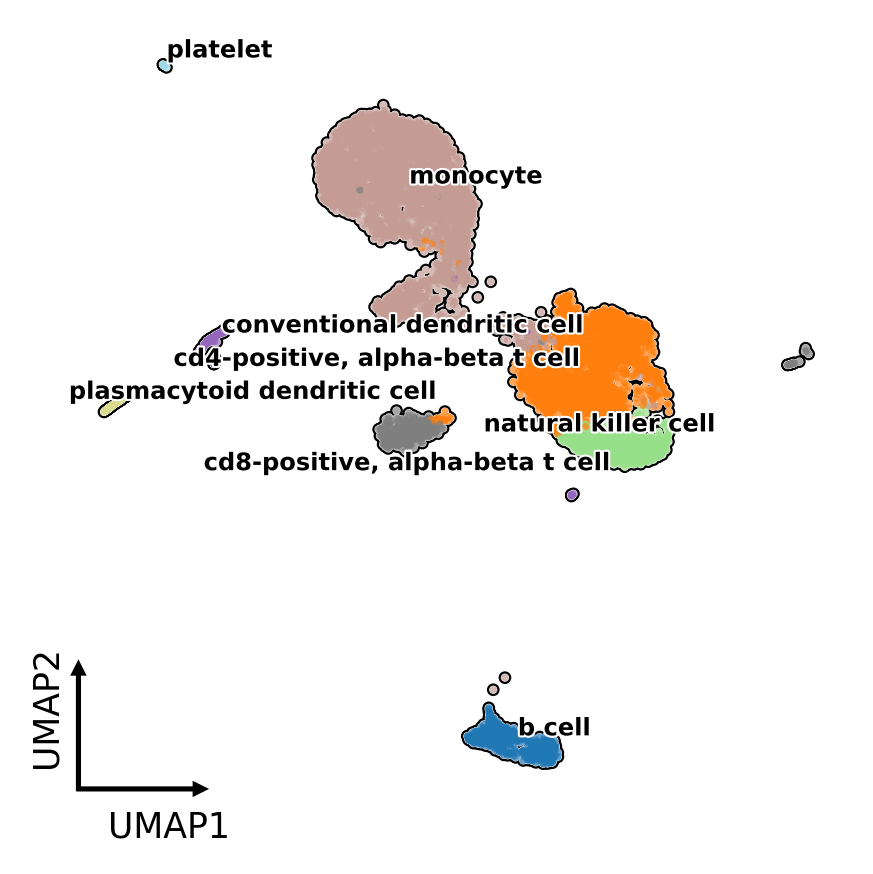

In [413]:
with ucd.pl.FigContext(figsize = (3,3), dpi = 300, simple_axes = True,
                        do_adjust_labels = True,simple_axes_padding=0.05) as ax:
    sc.pl.umap(adata_10k_src[adata_10k_src.obs.celltype.ne('unknown')], 
           color = 'celltype', palette = "tab20", ax = ax, show = False,
              legend_loc = 'on data', legend_fontoutline=True, add_outline=True,
              legend_fontsize = "xx-small", title = "", frameon = False)
    
    ax.get_figure().savefig("results/figure2_A.png", dpi = 300)

#### Hyperparameter Mixture Iterations (Supplementary Figure 2C)

##### Dropout Rate

In [ ]:
dropout_results_ucdbase_all = []
dropout_results_ucdselect_all = []
for dropout_fraction in tqdm(map(lambda x : round(x,2), np.linspace(0,1, 11)), total = 11, leave = False):
    print(f"Dropout Fraction: {dropout_fraction}")
    
    # Generate mixtures
    # Set random seeds
    rng = np.random.RandomState(0)
    random.seed(0)        

    # Generate a mixture
    opt_params = dict(size = 100, complexity = range(2,8), number = 500, random_state = 0,
                     mixture_pair_keys = mixture_pair_keys, dropout = dropout_fraction)
    
    adata_pbmc_mixture = ucd_old.tl.generate_mixtures(adata_10k_reference_pp, key = 'celltype', **opt_params)
    
    # Predict base
    ucp_mixture_pbmc, _, _ = ucd_old.tl.deconvolve(adata_pbmc_mixture, basemodel, split = True, propagate = True)    
    
    # Predict mixture
    ucd.ex.deconvolve_select(adata_pbmc_mixture, adata_5k_reference_pp, embeddingmodel, 
                         "celltype", method = 'both', verbosity = logging.INFO)
    
    res_unicell_base = pd.DataFrame(
        [[x[0], ucdexputils.ccc(adata_pbmc_mixture.obs[x[0]].values, ucp_mixture_pbmc[x[1]].values),
             scipy.stats.pearsonr(adata_pbmc_mixture.obs[x[0]].values, ucp_mixture_pbmc[x[1]].values)[0]] for \
         x in adata_pbmc_mixture.uns['mixture_pair_keys'] if x[1] in ucp_mixture_pbmc.columns]
        , columns = ['celltype', 'ccc', 'pearsonr'])
    res_unicell_base['dropout_rate'] = dropout_fraction
    dropout_results_ucdbase_all.append(res_unicell_base)
    
    
    preds = pd.DataFrame(adata_pbmc_mixture.obsm['predictions'], 
                         columns = adata_pbmc_mixture.uns['predictions_header'])

    common_celltypes = list(set(adata_pbmc_mixture.obs.columns).intersection(set(preds.columns)))
    res_ccc_ucd_select = pd.DataFrame([[c, ucdexputils.ccc(adata_pbmc_mixture.obs[c].values, preds[c].values),
                                            scipy.stats.pearsonr(adata_pbmc_mixture.obs[c].values, preds[c].values)[0]] \
                            for c in common_celltypes],columns = ['celltype', 'ccc', 'pearsonr']).set_index('celltype')
    res_ccc_ucd_select['dropout_rate'] = dropout_fraction
    dropout_results_ucdselect_all.append(res_ccc_ucd_select)

pd.concat(dropout_results_ucdbase_all).reset_index().to_csv("/home/jupyter/manuscript/figure2/results/pbmc/preds_pbmc_vs_dropout_ucdbase.csv")
pd.concat(dropout_results_ucdselect_all).reset_index().to_csv("/home/jupyter/manuscript/figure2/results/pbmc/preds_pbmc_vs_dropout_ucdselect.csv")

(3, 3)


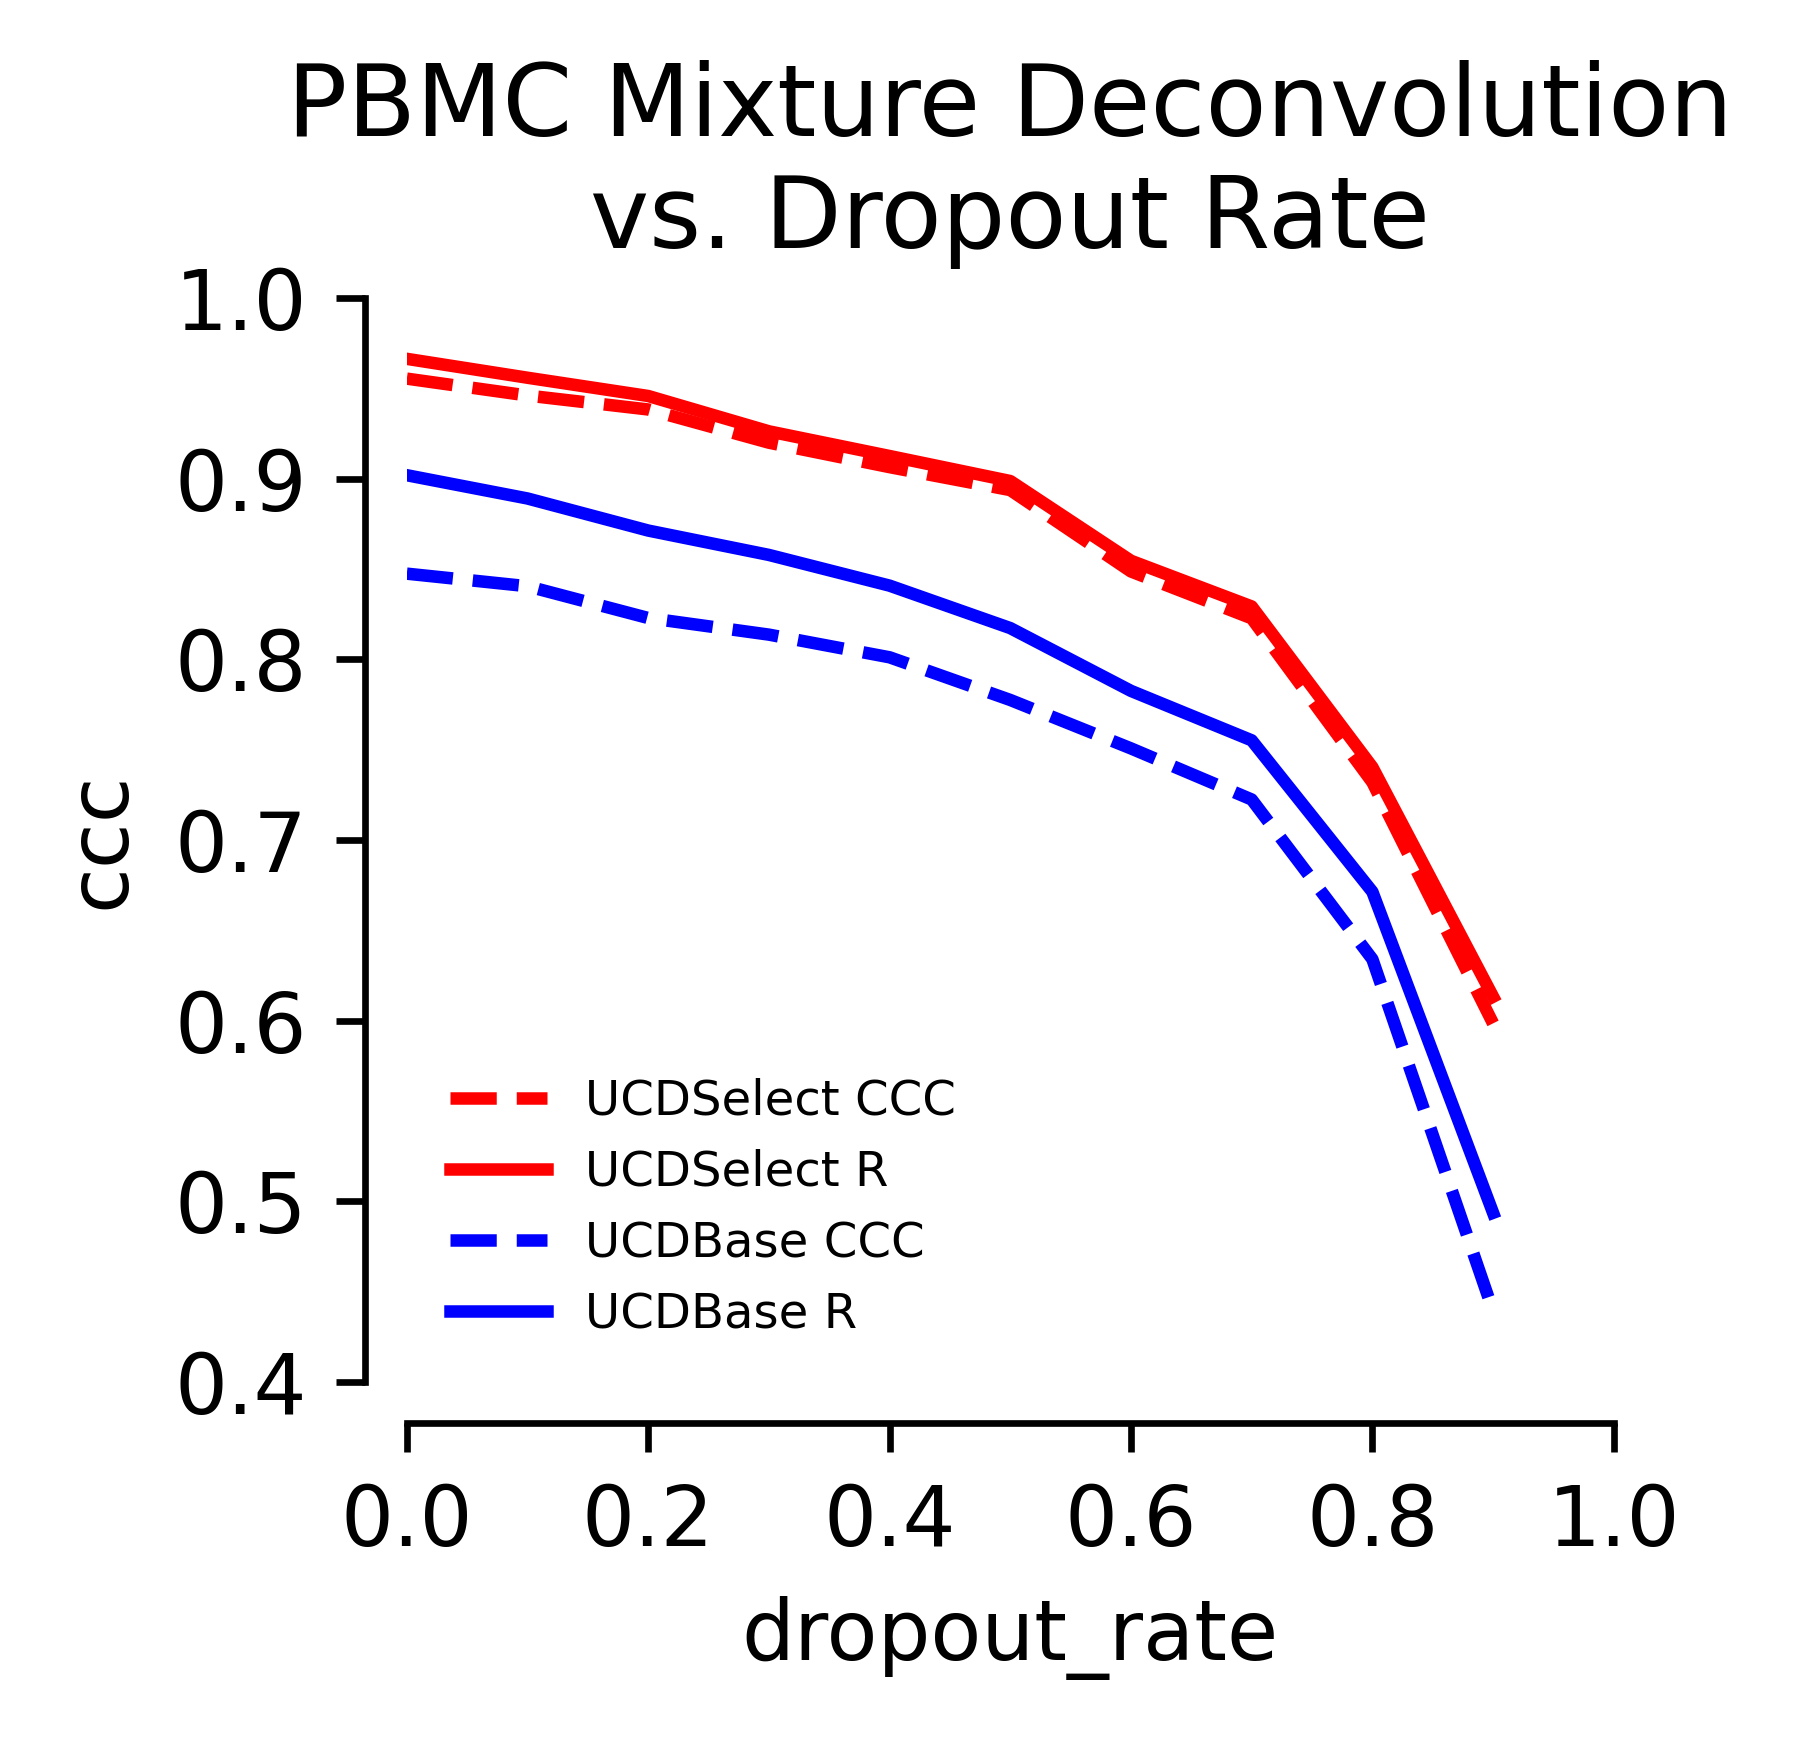

In [284]:
with ucd_old.pl.FigContext(dpi = 600, figsize = (3,3), despine = True) as ax:
    
    sns.lineplot(data = pd.concat(dropout_results_ucdselect_all).reset_index(), x = 'dropout_rate', 
                 y = 'ccc', color = 'r', linestyle = '--', ax = ax, ci=None)
    sns.lineplot(data = pd.concat(dropout_results_ucdselect_all).reset_index(), x = 'dropout_rate',
                 y = 'pearsonr', color = 'r', ax = ax, ci=None)
    sns.lineplot(data = pd.concat(dropout_results_ucdbase_all).reset_index(), x = 'dropout_rate',
                 y = 'ccc', color = 'b', linestyle = '--', ax = ax, ci=None)
    sns.lineplot(data = pd.concat(dropout_results_ucdbase_all).reset_index(), x = 'dropout_rate', 
                 y = 'pearsonr', color = 'b', ax = ax, ci=None)
    
    ax.set_xlim(0,1.0)
    ax.set_ylim(0.4,1.0)
    ax.legend(['UCDSelect CCC','UCDSelect R','UCDBase CCC','UCDBase R'], frameon = False, fontsize = 'xx-small')
    ax.set_title("PBMC Mixture Deconvolution\nvs. Dropout Rate")

##### Number of Unique Cells

In [ ]:
ncelltypes_results_ucdbase_all = []
ncelltypes_results_ucdselect_all = []
for n_cell_types in tqdm(range(1,9), total = len(list(range(1,9))), leave = False):
    print(f"Number Unique Cells: {n_cell_types}")
    
    
    # Generate mixtures
    # Set random seeds
    rng = np.random.RandomState(0)
    random.seed(0)        

    # Generate a mixture
    opt_params = dict(size = 100, complexity = n_cell_types, number = 500, random_state = 0,
                     mixture_pair_keys = mixture_pair_keys)
    
    adata_pbmc_mixture = ucd_old.tl.generate_mixtures(adata_10k_reference_pp, key = 'celltype', **opt_params)
    
    # Predict base
    ucp_mixture_pbmc, _, _ = ucd_old.tl.deconvolve(adata_pbmc_mixture, basemodel, split = True, propagate = True)   
    
    # Predict mixture
    ucd.ex.deconvolve_select(adata_pbmc_mixture, adata_5k_reference_pp, embeddingmodel, 
                         "celltype", method = 'both', verbosity = logging.INFO)
    
    res_unicell_base = pd.DataFrame(
        [[x[0], ucdexputils.ccc(adata_pbmc_mixture.obs[x[0]].values, ucp_mixture_pbmc[x[1]].values),
             scipy.stats.pearsonr(adata_pbmc_mixture.obs[x[0]].values, ucp_mixture_pbmc[x[1]].values)[0]] for \
         x in adata_pbmc_mixture.uns['mixture_pair_keys'] if x[1] in ucp_mixture_pbmc.columns]
        , columns = ['celltype', 'ccc', 'pearsonr'])
    res_unicell_base['ncelltypes'] = n_cell_types
    ncelltypes_results_ucdbase_all.append(res_unicell_base)
    
    preds = pd.DataFrame(adata_pbmc_mixture.obsm['predictions'], 
                         columns = adata_pbmc_mixture.uns['predictions_header'])

    common_celltypes = list(set(adata_pbmc_mixture.obs.columns).intersection(set(preds.columns)))
    res_ccc_ucd_select = pd.DataFrame([[c, ucdexputils.ccc(adata_pbmc_mixture.obs[c].values, preds[c].values),
                                            scipy.stats.pearsonr(adata_pbmc_mixture.obs[c].values, preds[c].values)[0]] \
                            for c in common_celltypes],columns = ['celltype', 'ccc', 'pearsonr']).set_index('celltype')
    res_ccc_ucd_select['ncelltypes'] = n_cell_types
    ncelltypes_results_ucdselect_all.append(res_ccc_ucd_select)

pd.concat(ncelltypes_results_ucdbase_all).reset_index().to_csv("/home/jupyter/manuscript/figure2/results/pbmc/preds_pbmc_vs_ncelltypes_ucdbase.csv")
pd.concat(ncelltypes_results_ucdselect_all).reset_index().to_csv("/home/jupyter/manuscript/figure2/results/pbmc/preds_pbmc_vs_ncelltypes_ucdselect.csv")

(3, 3)


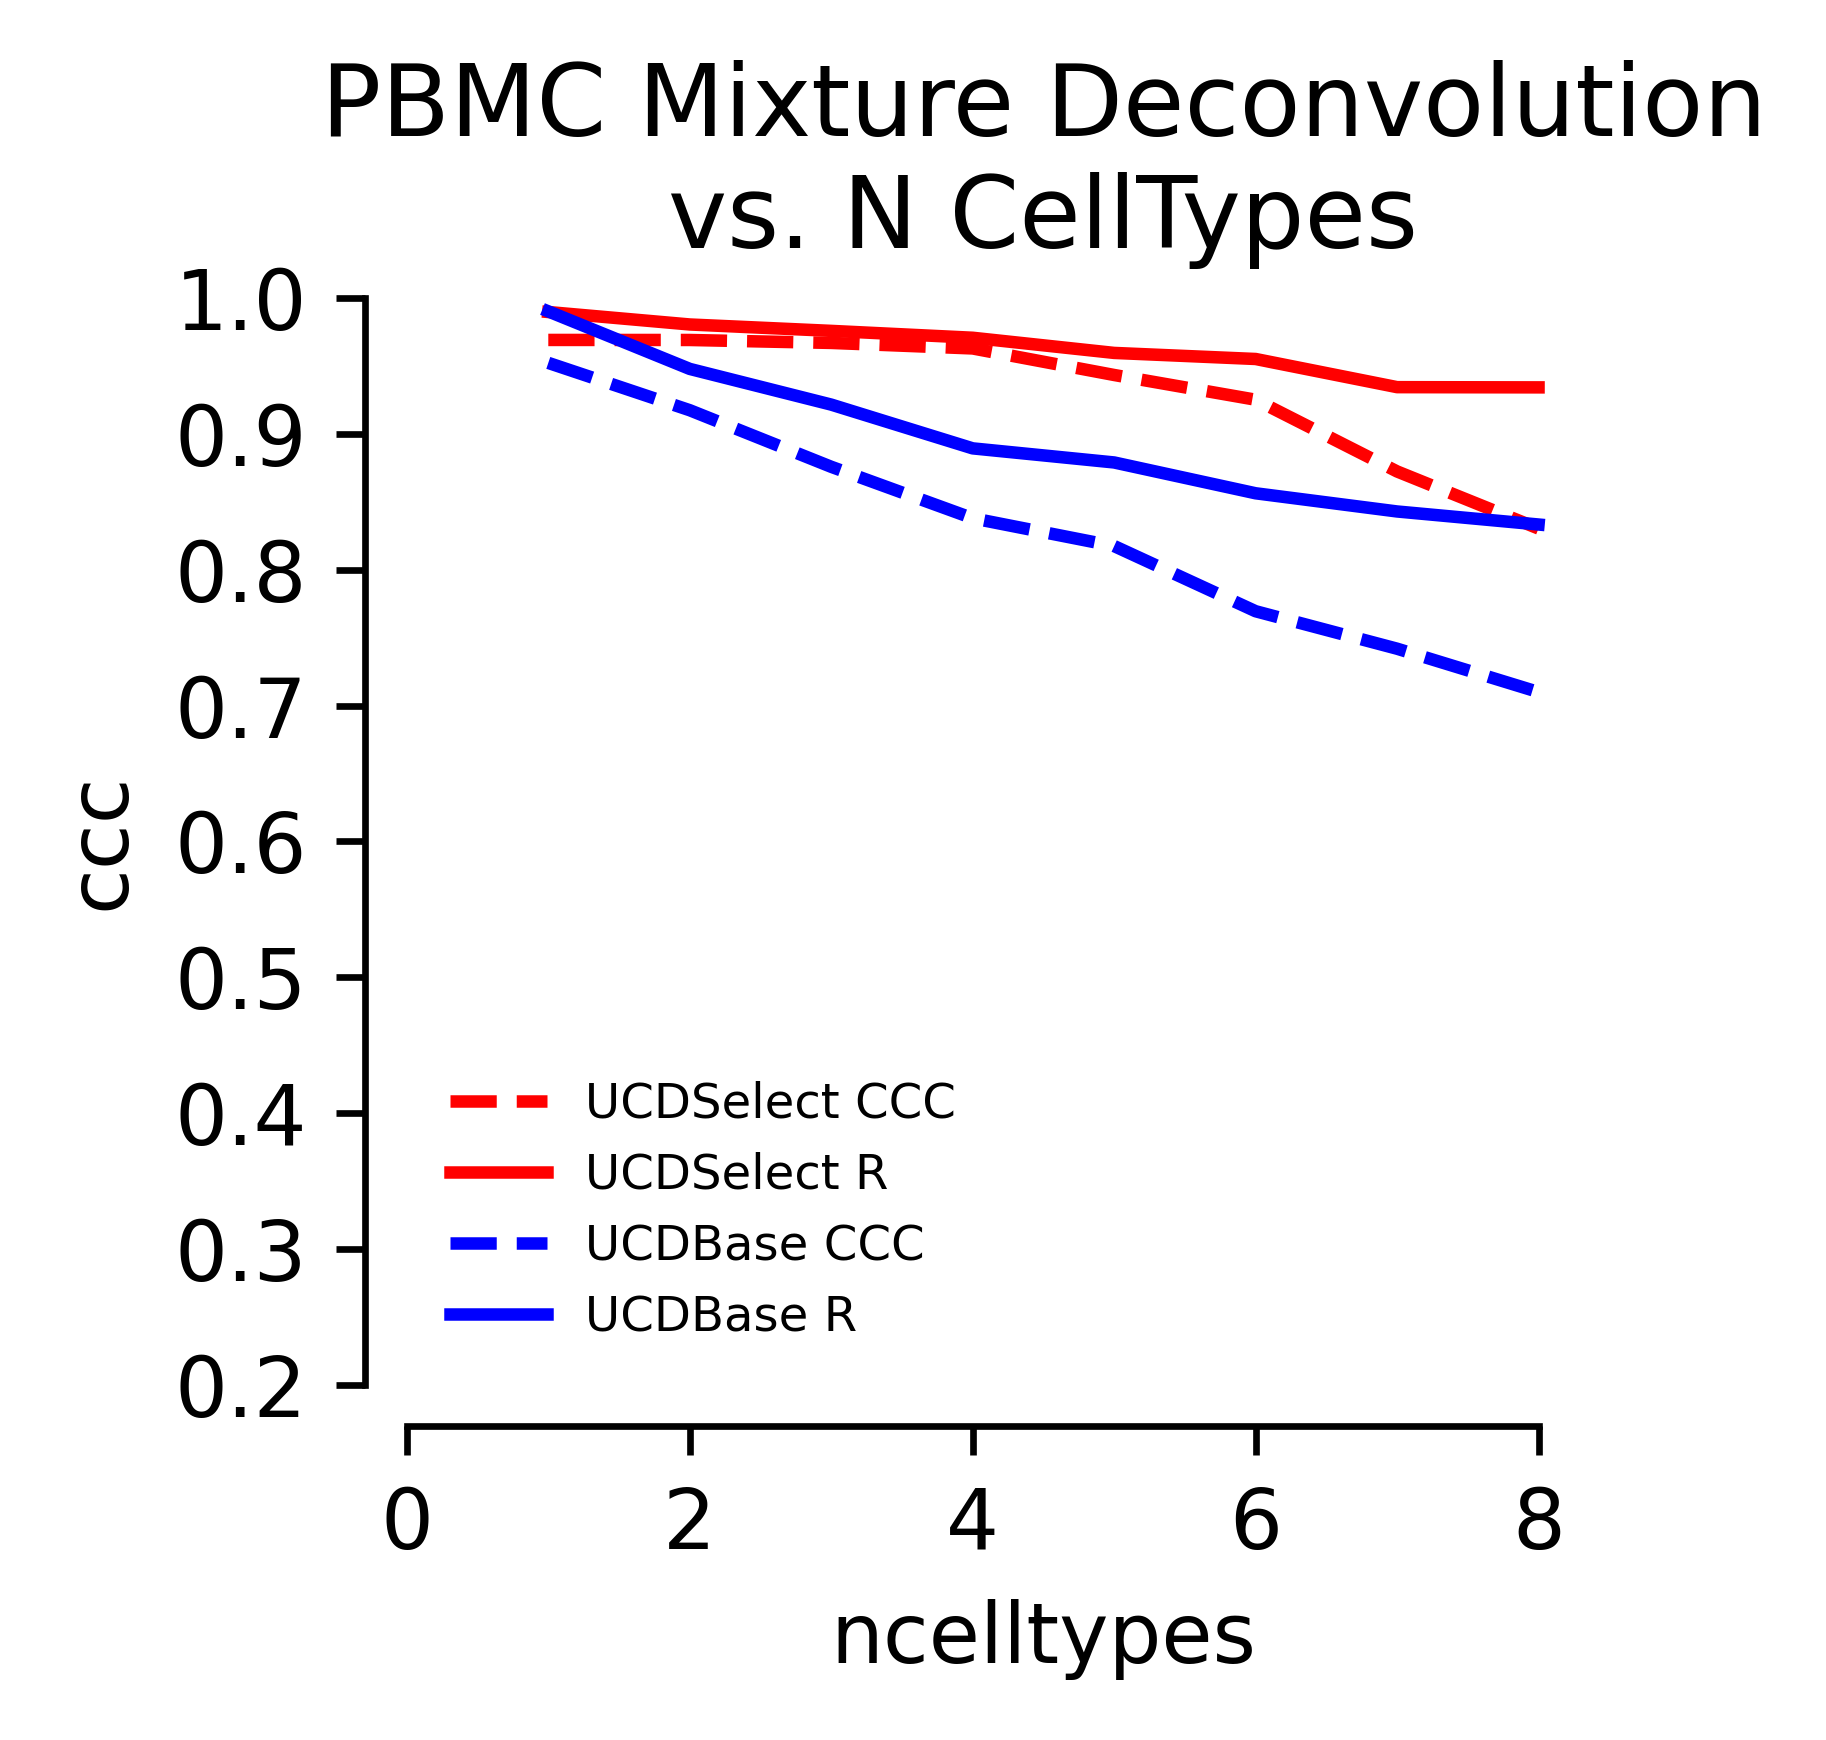

In [286]:
with ucd_old.pl.FigContext(dpi = 600, figsize = (3,3), despine = True) as ax:
    
    sns.lineplot(data = pd.concat(ncelltypes_results_ucdselect_all).reset_index(), x = 'ncelltypes', 
                 y = 'ccc', color = 'r', linestyle = '--', ax = ax, ci=None)
    sns.lineplot(data = pd.concat(ncelltypes_results_ucdselect_all).reset_index(), x = 'ncelltypes',
                 y = 'pearsonr', color = 'r', ax = ax, ci=None)
    sns.lineplot(data = pd.concat(ncelltypes_results_ucdbase_all).reset_index(), x = 'ncelltypes',
                 y = 'ccc', color = 'b', linestyle = '--', ax = ax, ci=None)
    sns.lineplot(data = pd.concat(ncelltypes_results_ucdbase_all).reset_index(), x = 'ncelltypes', 
                 y = 'pearsonr', color = 'b', ax = ax, ci=None)
    
    ax.set_xlim(0.0,9.0)
    ax.set_ylim(0.2,1.0)
    ax.legend(['UCDSelect CCC','UCDSelect R','UCDBase CCC','UCDBase R'], frameon = False, fontsize = 'xx-small')
    ax.set_title("PBMC Mixture Deconvolution\nvs. N CellTypes")

#### Size of Samples

In [ ]:
samplesize_results_ucdbase_all = []
samplesize_results_ucdselect_all = []
for samplesize in tqdm([10, 25, 50, 100, 200, 250, 500, 750, 1000], leave = False):
    print(f"SampleSize: {samplesize}")
    
    
    # Generate mixtures
    # Set random seeds
    rng = np.random.RandomState(0)
    random.seed(0)        

    # Generate a mixture
    opt_params = dict(size = samplesize, complexity = range(2,8), number = 500, random_state = 0,
                     mixture_pair_keys = mixture_pair_keys)
    
    adata_pbmc_mixture = ucd_old.tl.generate_mixtures(adata_10k_reference_pp, key = 'celltype', **opt_params)
    
    # Predict base
    ucp_mixture_pbmc, _, _ = ucd_old.tl.deconvolve(adata_pbmc_mixture, basemodel, split = True, propagate = True)   
    
    # Predict mixture
    ucd.ex.deconvolve_select(adata_pbmc_mixture, adata_5k_reference_pp, embeddingmodel, 
                         "celltype", method = 'both', verbosity = logging.INFO)
    
    res_unicell_base = pd.DataFrame(
        [[x[0], ucdexputils.ccc(adata_pbmc_mixture.obs[x[0]].values, ucp_mixture_pbmc[x[1]].values),
             scipy.stats.pearsonr(adata_pbmc_mixture.obs[x[0]].values, ucp_mixture_pbmc[x[1]].values)[0]] for \
         x in adata_pbmc_mixture.uns['mixture_pair_keys'] if x[1] in ucp_mixture_pbmc.columns]
        , columns = ['celltype', 'ccc', 'pearsonr'])
    res_unicell_base['samplesize'] = samplesize
    samplesize_results_ucdbase_all.append(res_unicell_base)
    
    
    preds = pd.DataFrame(adata_pbmc_mixture.obsm['predictions'], 
                         columns = adata_pbmc_mixture.uns['predictions_header'])

    common_celltypes = list(set(adata_pbmc_mixture.obs.columns).intersection(set(preds.columns)))
    res_ccc_ucd_select = pd.DataFrame([[c, ucdexputils.ccc(adata_pbmc_mixture.obs[c].values, preds[c].values),
                                            scipy.stats.pearsonr(adata_pbmc_mixture.obs[c].values, preds[c].values)[0]] \
                            for c in common_celltypes],columns = ['celltype', 'ccc', 'pearsonr']).set_index('celltype')
    res_ccc_ucd_select['samplesize'] = samplesize
    samplesize_results_ucdselect_all.append(res_ccc_ucd_select)

pd.concat(samplesize_results_ucdbase_all).reset_index().to_csv("/home/jupyter/manuscript/figure2/results/pbmc/preds_pbmc_vs_samplesize_ucdbase.csv")
pd.concat(samplesize_results_ucdselect_all).reset_index().to_csv("/home/jupyter/manuscript/figure2/results/pbmc/preds_pbmc_vs_samplesize_ucdselect.csv")

(3, 3)


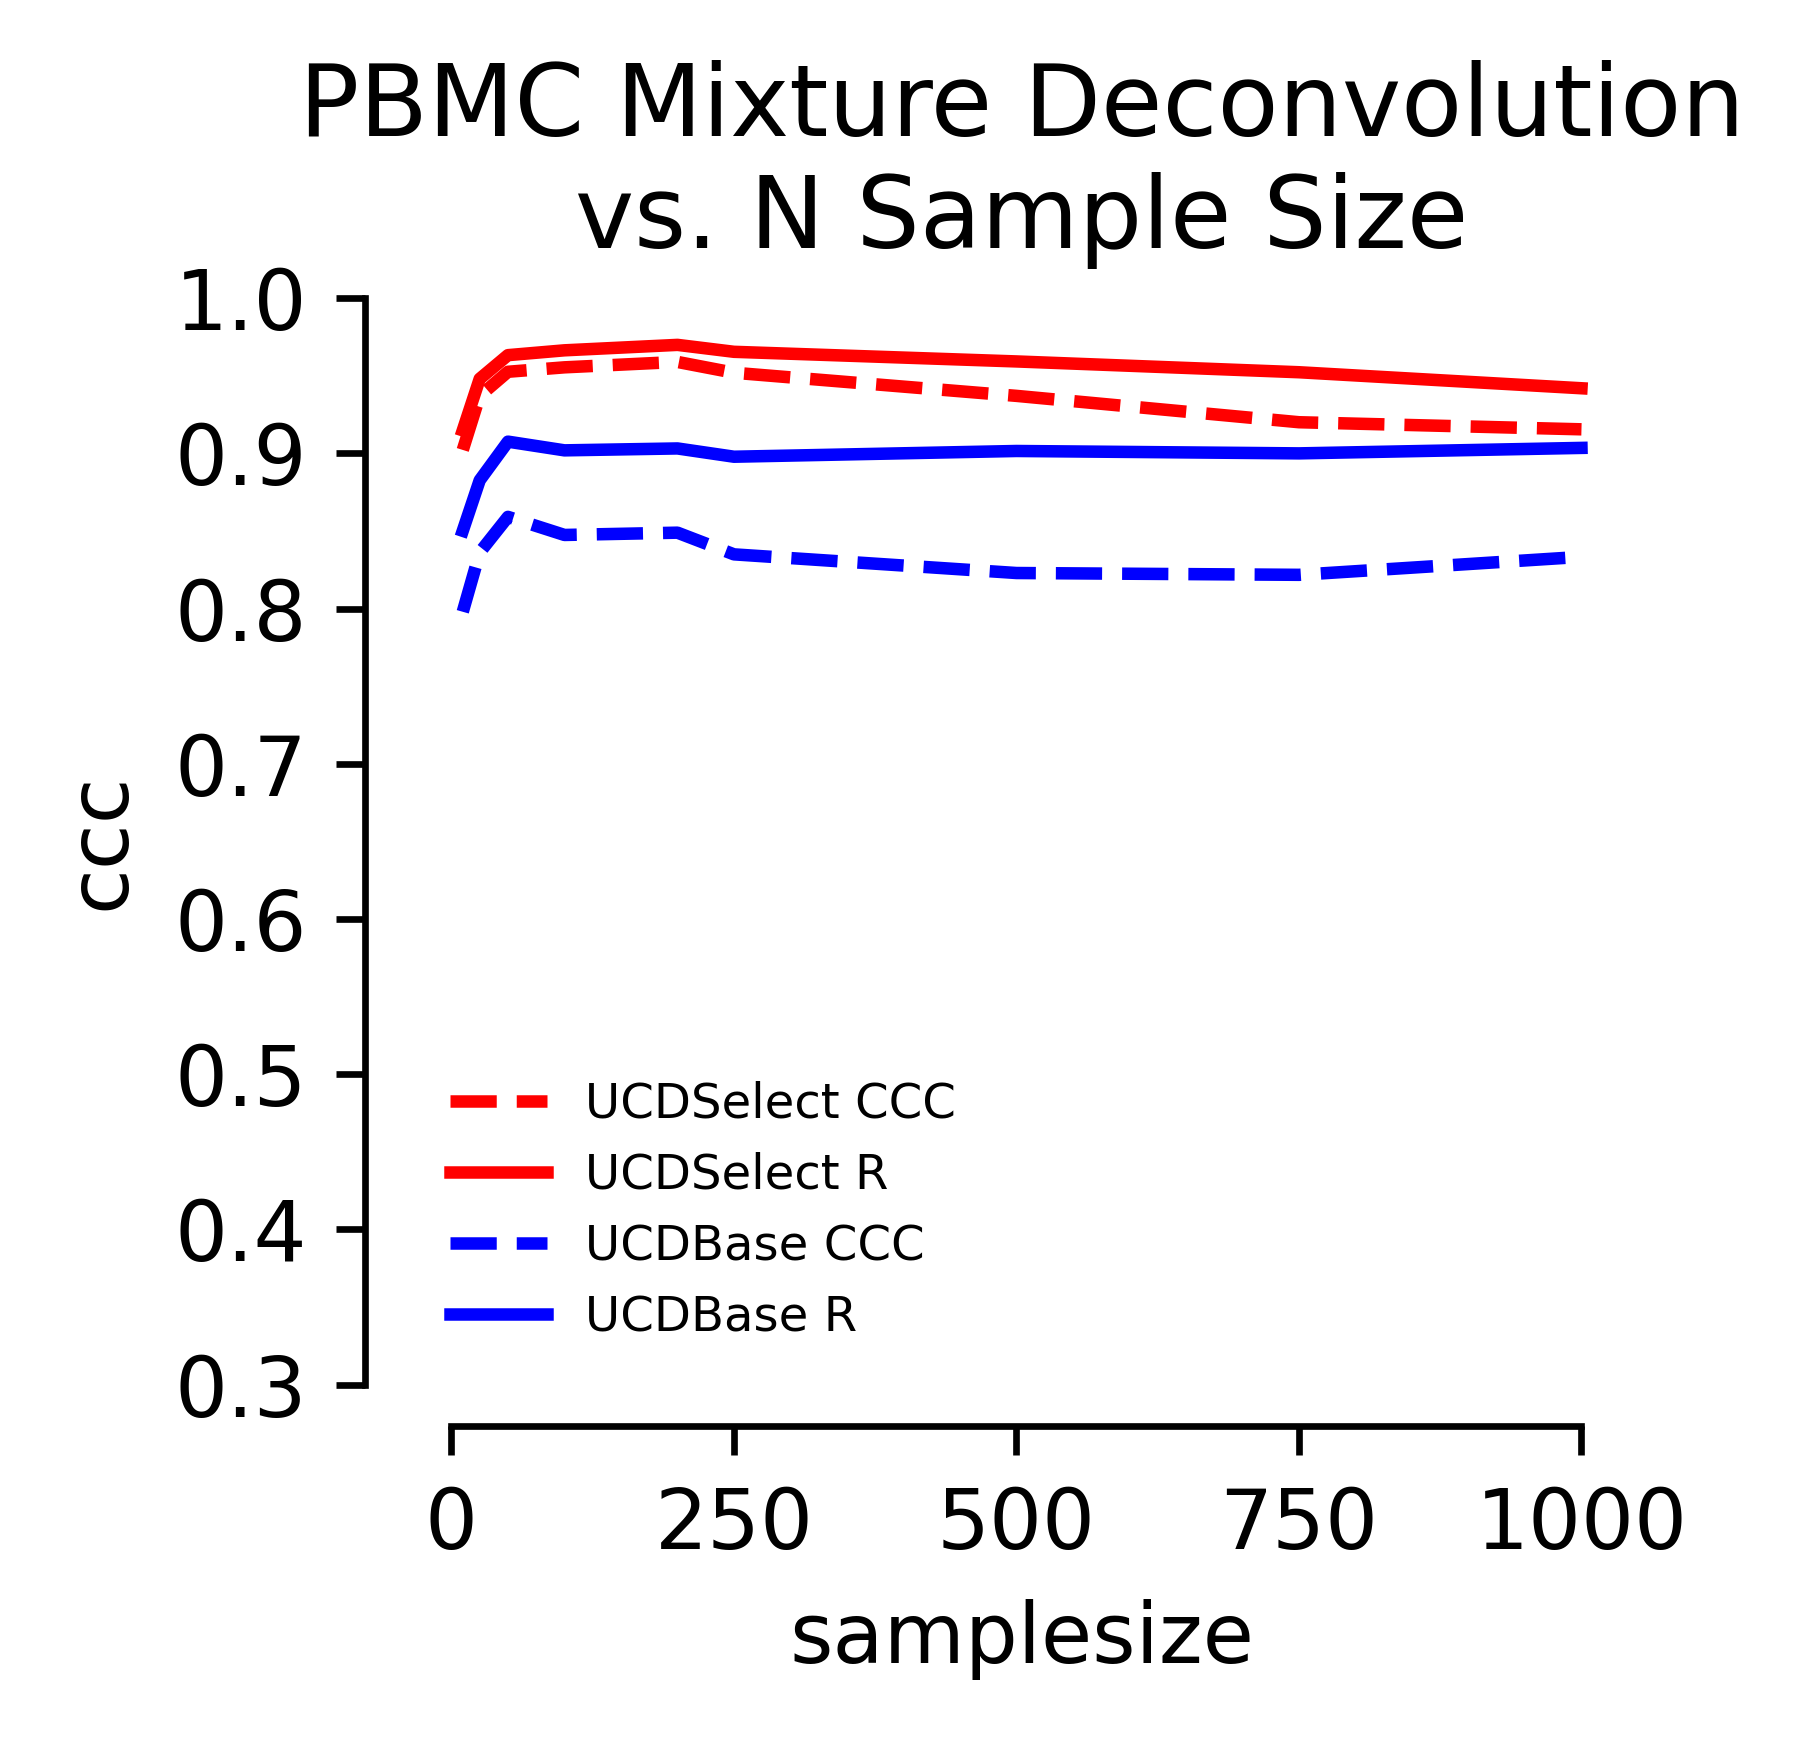

In [283]:
with ucd_old.pl.FigContext(dpi = 600, figsize = (3,3), despine = True) as ax:
    
    sns.lineplot(data = pd.concat(samplesize_results_ucdselect_all).reset_index(), x = 'samplesize', 
                 y = 'ccc', color = 'r', linestyle = '--', ax = ax, ci=None)
    sns.lineplot(data = pd.concat(samplesize_results_ucdselect_all).reset_index(), x = 'samplesize',
                 y = 'pearsonr', color = 'r', ax = ax, ci=None)
    sns.lineplot(data = pd.concat(samplesize_results_ucdbase_all).reset_index(), x = 'samplesize',
                 y = 'ccc', color = 'b', linestyle = '--', ax = ax, ci=None)
    sns.lineplot(data = pd.concat(samplesize_results_ucdbase_all).reset_index(), x = 'samplesize', 
                 y = 'pearsonr', color = 'b', ax = ax, ci=None)
    
    #ax.set_xlim(0.0,20.0)
    ax.set_ylim(0.3,1.0)
    ax.legend(['UCDSelect CCC','UCDSelect R','UCDBase CCC','UCDBase R'], frameon = False, fontsize = 'xx-small')
    ax.set_title("PBMC Mixture Deconvolution\nvs. N Sample Size")

#### Methods Comparison

##### UCDBase

In [ ]:
ucp_preds_pbmc, _, _ = ucd_old.tl.deconvolve(adata_10k_mixture_pp, basemodel, split = True, propagate = True)
ucp_preds_pbmc[[x[1] for x in adata_10k_mixture_pp.uns['mixture_pair_keys']]].to_csv(
    "/home/jupyter/manuscript/figure2/results/pbmc/preds_pbmc_UCDBase.csv")

##### UCDSelect

In [ ]:
ucd.ex.deconvolve_select(adata_10k_mixture_pp, adata_5k_reference_pp, embeddingmodel, "celltype", 
                                       method = "both", verbosity = logging.DEBUG)
preds = pd.DataFrame(adata_10k_mixture_pp.obsm['predictions'], 
                     columns = adata_10k_mixture_pp.uns['predictions_header'])
preds.to_csv("/home/jupyter/manuscript/figure2/results/pbmc/preds_pbmc_UCDSelect-Both.csv")

In [ ]:
ucd.ex.deconvolve_select(adata_10k_mixture_pp, adata_5k_reference_pp, embeddingmodel, "celltype", 
                                       method = "embeddings", verbosity = logging.DEBUG)
preds = pd.DataFrame(adata_10k_mixture_pp.obsm['predictions'], 
                     columns = adata_10k_mixture_pp.uns['predictions_header'])
preds.to_csv("/home/jupyter/manuscript/figure2/results/pbmc/preds_pbmc_UCDSelect-Embeddings.csv")

In [ ]:
ucd.ex.deconvolve_select(adata_10k_mixture_pp, adata_5k_reference_pp, embeddingmodel, "celltype", 
                                       method = "features", verbosity = logging.DEBUG)
preds = pd.DataFrame(adata_10k_mixture_pp.obsm['predictions'], 
                     columns = adata_10k_mixture_pp.uns['predictions_header'])
preds.to_csv("/home/jupyter/manuscript/figure2/results/pbmc/preds_pbmc_UCDSelect-Features.csv")

##### Plot Comparator Results (Figure 2B)

In [20]:
from ucdeconvolve.ucdeconvolve._experimental._exputils import ccc
from scipy.stats import pearsonr

In [58]:
adata_mixture = adata_10k_mixture_pp
adata_reference = adata_5k_reference_pp

basepath = "/home/jupyter/manuscript/figure2/results/pbmc"
common_celltypes = list(set(adata_reference.obs.celltype))

fnames = glob.glob(os.path.join(basepath,"*.tsv")) + glob.glob(os.path.join(basepath,"*.csv"))
fnames = [x for x in fnames if not (("MUSIC_old" in x) or ("LM22" in x))]

res_all = []
for fname in fnames:
    method = fname.rsplit("_",1)[-1].split(".")[0].lower()
    res = pd.read_table(fname, sep = "\t" if fname.endswith(".tsv") else ",")
    res.columns = res.columns.str.replace("_"," ").str.replace(" positive", "-positive,").str.replace("alpha beta","alpha-beta")
    res = res.reindex(columns = common_celltypes)
    
    for celltype in adata_mixture.obs.columns:
            try:
                val_pearsonr, pval = pearsonr(adata_mixture.obs[celltype], res[celltype])
                val_ccc = ccc(adata_mixture.obs[celltype], res[celltype])
            except:
                continue
            res_all.append([method, celltype, val_pearsonr, val_ccc, pval])
            
res_all = pd.DataFrame(res_all, columns = ['method','celltype', 'pearsonr', 'ccc','pval'])

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [54]:
naming_remapper = {
    "stereoscope" : "Stereoscope",
    "cell2location" : "Cell2Location",
    "destvi" : "DestVI",
    "tangram" : "Tangram",
    "ucdselect-features" : "Features",
    "cibersortx" : "CIBERSORTx",
    "spotlight" : "SPOTlight",
    "ucdselect-both" : "Both",
    "rctd" : "RCTD",
    "ucdselect-embeddings" : "Embeddings",
    "ucdbase" : "Base",
    "scdc" : "SCDC",
    "music" : "MuSiC"
}

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


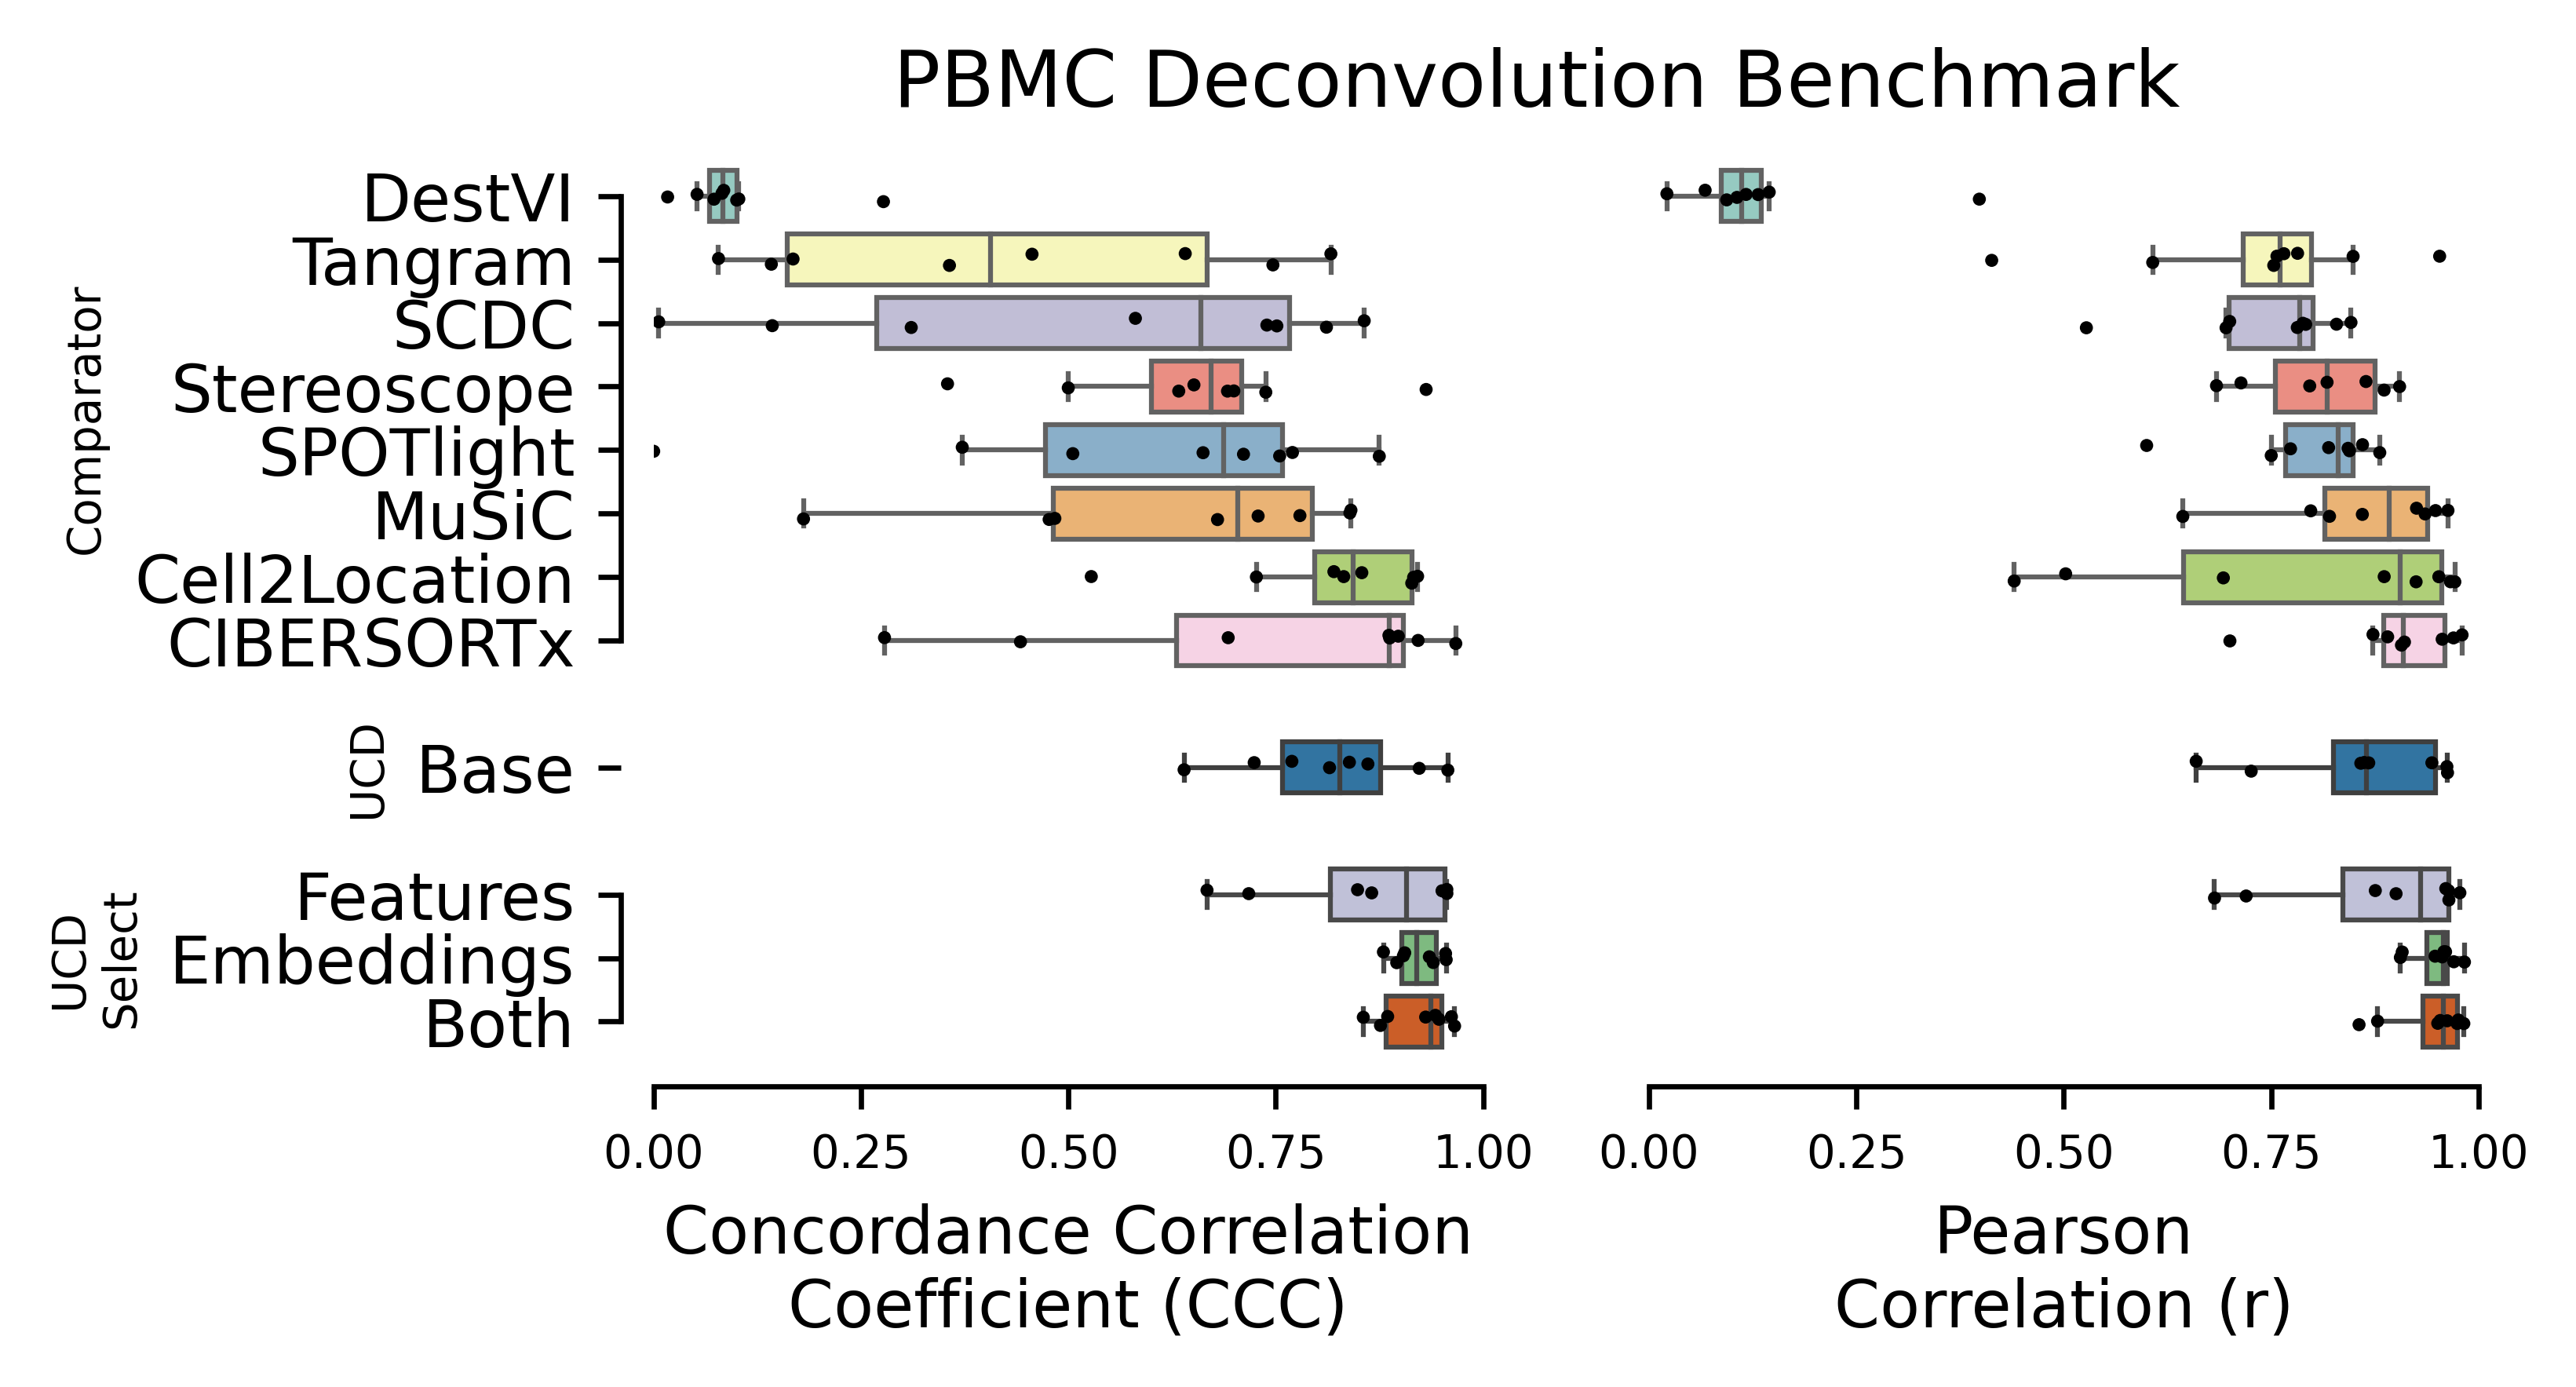

In [57]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import textwrap

def trim(ax_i):
    
    xticks = np.asarray(ax_i.get_xticks())
    if xticks.size:
        firsttick = np.compress(xticks >= min(ax_i.get_xlim()),
                                xticks)[0]
        lasttick = np.compress(xticks <= max(ax_i.get_xlim()),
                               xticks)[-1]
        ax_i.spines['bottom'].set_bounds(firsttick, lasttick)
        ax_i.spines['top'].set_bounds(firsttick, lasttick)
        newticks = xticks.compress(xticks <= lasttick)
        newticks = newticks.compress(newticks >= firsttick)
        ax_i.set_xticks(newticks)

    yticks = np.asarray(ax_i.get_yticks())
    if yticks.size:
        firsttick = np.compress(yticks >= min(ax_i.get_ylim()),
                                yticks)[0]
        lasttick = np.compress(yticks <= max(ax_i.get_ylim()),
                               yticks)[-1]
        ax_i.spines['left'].set_bounds(firsttick, lasttick)
        ax_i.spines['right'].set_bounds(firsttick, lasttick)
        newticks = yticks.compress(yticks <= lasttick)
        newticks = newticks.compress(newticks >= firsttick)
        ax_i.set_yticks(newticks)
        

naming_remapper = {
    "stereoscope" : "Stereoscope",
    "cell2location" : "Cell2Location",
    "destvi" : "DestVI",
    "tangram" : "Tangram",
    "ucdselect-features" : "Features",
    "cibersortx" : "CIBERSORTx",
    "spotlight" : "SPOTlight",
    "ucdselect-both" : "Both",
    "rctd" : "RCTD",
    "ucdselect-embeddings" : "Embeddings",
    "ucdbase" : "Base",
    "scdc" : "SCDC",
    "music" : "MuSiC"
}

gs_kw = dict(width_ratios=[1,1], height_ratios=[8,1,3], hspace=0.25)
fig, axes = plt.subplots(3, 2, figsize = (5,2.5), dpi = 600, sharex = True, sharey = False, gridspec_kw=gs_kw)
axes = axes.T
y = 'method'
x = 'pearsonr'

for i,x in enumerate(['ccc', 'pearsonr']):
    res_noucd = res_all[~res_all.method.str.contains("ucd")]
    res_ucdbase = res_all[res_all.method.str.contains("ucdbase")]
    res_ucdselect = res_all[res_all.method.str.contains("ucdselect")]

    res_noucd.method = res_noucd.method.map(naming_remapper)
    res_ucdbase.method = res_ucdbase.method.map(naming_remapper)
    res_ucdselect.method = res_ucdselect.method.map(naming_remapper)

    order = res_noucd.groupby(y)[x].median().sort_values(ascending = False).index.tolist()[::-1]
    sns.boxplot(data = res_noucd, x = x, y = y, order = order,
             ax = axes[i,0], linewidth = 0.75, palette = 'Set3', fliersize = 0)
    sns.stripplot(data = res_noucd, x = x, y = y, order = order,color = 'k', size = 2, ax = axes[i,0], jitter = True)

    axes[i,0].set_ylabel('Comparator', fontsize = "x-small")
    axes[i,0].set_xlabel('')
    axes[i,0].tick_params(bottom=False)
    axes[i,0].set_xlim(0,1.0)

    for spine in ['bottom', 'right', 'top']:
        axes[i,0].spines[spine].set_visible(False)
    for side in ['left']:
        axes[i,0].spines[side].set_position(('outward', 5))
    trim(axes[i,0])

    order = res_ucdbase.groupby(y)[x].median().sort_values(ascending = False).index.tolist()[::-1]
    sns.boxplot(data = res_ucdbase, x = x, y = y, order = order,
             ax = axes[i,1], linewidth = 0.75, palette = 'tab10', fliersize = 0)
    sns.stripplot(data = res_ucdbase, x = x, y = y, order = order,color = 'k', size = 2, ax = axes[i,1], jitter = True)

    axes[i,1].set_ylabel('UCD',  fontsize = "x-small")
    axes[i,1].tick_params(bottom=False)
    axes[i,1].set_xlabel('')
    for spine in ['bottom', 'right', 'top']:
        axes[i,1].spines[spine].set_visible(False)
    for side in ['left']:
        axes[i,1].spines[side].set_position(('outward', 5))
    trim(axes[i,1])


    order = res_ucdselect.groupby(y)[x].median().sort_values(ascending = False).index.tolist()[::-1]
    sns.boxplot(data = res_ucdselect, x = x, y = y, order = order,
             ax = axes[i,2], linewidth = 0.75, palette = 'tab20c_r', fliersize = 0)
    sns.stripplot(data = res_ucdselect, x = x, y = y, order = order,color = 'k', size = 2, ax = axes[i,2], jitter = True)


    axes[i,2].set_ylabel('UCD\nSelect', fontsize = "x-small")
    axes[i,2].tick_params(bottom=True)
    axes[i,2].set_xlabel('')
    for side in ['right', 'top']:
        axes[i,2].spines[side].set_visible(False)
    for side in ['left', 'bottom']:
        axes[i,2].spines[side].set_position(('outward', 5))
    trim(axes[i,2]) 
    axes[i,2].set_xlim(0,1.0)
    
    # Hide things if we are on the right side
    if i == 1:
        for ax in axes[i,:]:
            for side in ['left']:
                ax.spines[side].set_visible(False)
                ax.tick_params(left=False)
                ax.yaxis.set_ticklabels([])
                ax.set_ylabel("")

    axes[0,-1].set_xlabel("Concordance Correlation\nCoefficient (CCC)")
    axes[1,-1].set_xlabel("Pearson\nCorrelation (r)")
    for k in range(0,2): axes[k,-1].tick_params(axis = 'x', which = 'major', labelsize = 'x-small')

    fig.align_ylabels(axes[:,0])
    fig.suptitle("PBMC Deconvolution Benchmark")